# Find the correlation between mass and radius for planets using k-means clustering, linear regression, and data from the NASA exoplanet archive

## Introduction

Chen and Kipping (2016) found a linear relationship between mass and radius for astronomical bodies ranging in mass from moons to stars. Using the commonly accepted definitions of mass ranges for bodies, they divided their data up into four bins: "Terran worlds", "Neptunian worlds", "Jovian worlds", and "Stellar worlds". Though astrophysically motivated, the dividing lines between these mass ranges is not universal.

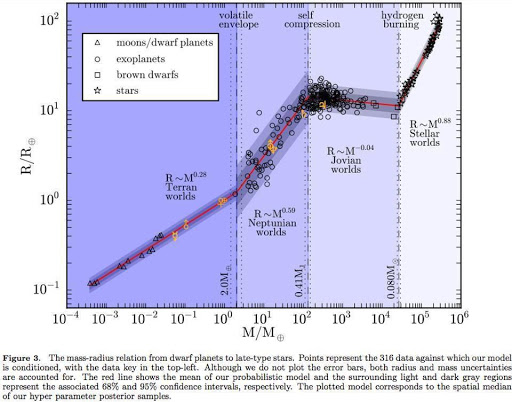

## This work
In this notebook, I aim to take data from the NASA exoplanet archive and search for the mass-radius relation from the unstructed data alone, without hardcoded breakpoints. I use k-means clustering with varying k (number of clusters) from 2 to 6. I divide the data into training and testing data and perform linear regression on those points. I assess the accuracy of the model using the Mean Absolute Error (MAE).

Note: since the data are only from the NASA exoplanet archive, they do not include stars so the fourth category of bodies, on the right of this diagram "Stellar worlds" will not be included in this analysis.

In [1]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import r2_score
import math

## k-Means on the exoplanet archive data



## Read in the exoplanet archive data

In [2]:
df = pd.read_csv("EA_mass_radius_plus_moons.csv")

# take a look at the dataset
df.head()


,pl_name,default_flag,pl_rade,pl_bmasse
0,2MASS J02192210-3925225 b,1.0,16.141,4417.8370
1,2MASS J21402931+1625183 A b,1.0,10.310,6657.4800
2,55 Cnc e,1.0,1.910,8.0800
3,AU Mic b,1.0,4.203,57.2094
4,BD+20 594 b,1.0,2.578,22.2481


In [3]:
cdf = df[['pl_bmasse','pl_rade']]

## Find and remove outliers

In [4]:
outliers=np.where((cdf.pl_bmasse>10**2)&(cdf.pl_rade<7))[0]
odf= cdf.drop(outliers)

(-1, 2)

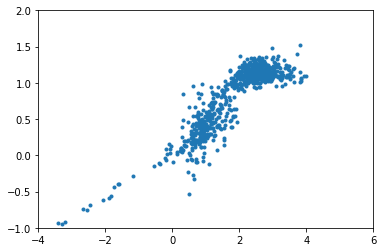

In [5]:
ldf=np.log10(odf.values)
plt.scatter(ldf[:, 0], ldf[:, 1], marker='.')
plt.xlim(-4,6)
plt.ylim(-1,2)

## K-means clustering

In [6]:
def k_means_func(num_clusters):
    k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
    k_means.fit(ldf)
    k_means_labels = k_means.labels_
    k_means_cluster_centers = k_means.cluster_centers_
    return k_means, k_means_labels, k_means_cluster_centers

## Training/test data and Regression

In [7]:
def reg_on_clusters(k_means, k_means_labels, k_means_cluster_centers, num_clusters):
    reg_fit_x=np.zeros((len(k_means.cluster_centers_),2))
    reg_fit_y=np.zeros((len(k_means.cluster_centers_),2))
    variance=np.zeros(len(k_means.cluster_centers_))

    ##Now do a linear regression on each of these clusters
    for k in range(len(k_means.cluster_centers_)):
    #     print(k)

        # Create a list of all data points, where the data poitns that are 
        # in the cluster (ex. cluster 0) are labeled as true, else they are
        # labeled as false.
        my_members = (k_means_labels == k)

        # Define the centroid, or cluster center.
        cluster_center = k_means_cluster_centers[k]

        ##Pull out the data as variables 
        mass=ldf[my_members, 0]
        rad=ldf[my_members, 1]

        ###Break up the data into training and testing datasets

        msk = np.random.rand(len(mass)) < 0.8
        train_mass = mass[msk]
        test_mass = mass[~msk]
        train_rad = rad[msk]
        test_rad = rad[~msk]

        ##Train the data
        regr = linear_model.LinearRegression()
        train_x = train_mass.reshape(train_mass.shape[0],-1) ### to make it the right dimensions
        train_y = train_rad.reshape(train_rad.shape[0],-1)  
        regr.fit (train_x, train_y)


        test_x = np.asanyarray(test_mass.reshape(test_mass.shape[0],-1))
        test_y = np.asanyarray(test_rad.reshape(test_rad.shape[0],-1))
        test_y_ = regr.predict(test_x)

        variance[k]= np.mean(np.absolute(test_y_ - test_y))#regr.score(test_x, test_y)

        min_x=np.argmin(train_x)
        max_x=np.argmax(train_x)

        reg_fit_x[k,:]=np.array((train_x[min_x][0],train_x[max_x][0]))
        reg_fit_y[k,:]=regr.coef_[0][0]*np.array((train_x[min_x][0],train_x[max_x][0])) + regr.intercept_[0]

    return variance, reg_fit_x, reg_fit_y

## Visualize the data, show the clusters in different colors and the linear regression fit

In [8]:
def make_plot(k_means, k_means_labels, k_means_cluster_centers, num_clusters, variance, reg_fit_x, reg_fit_y):
    # Initialize the plot with the specified dimensions.
    fig = plt.figure(figsize=(6, 4))

    # Colors uses a color map, which will produce an array of colors based on
    # the number of labels there are. We use set(k_means_labels) to get the
    # unique labels.
    colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

    # Create a plot
    ax = fig.add_subplot(1, 1, 1)

    # For loop that plots the data points and centroids.
    # k will range from 0-3, which will match the possible clusters that each
    # data point is in.
    for k, col in zip(range(len(k_means.cluster_centers_)), colors):

        # Create a list of all data points, where the data poitns that are 
        # in the cluster (ex. cluster 0) are labeled as true, else they are
        # labeled as false.
        my_members = (k_means_labels == k)

        # Define the centroid, or cluster center.
        cluster_center = k_means_cluster_centers[k]

        # Plots the datapoints with color col.
        ax.plot(ldf[my_members, 0], ldf[my_members, 1], 'w', markerfacecolor=col, marker='.')

        # Plots the centroids with specified color, but with a darker outline
        ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

        #ax.text(cluster_center[0]-0.3,cluster_center[1]+0.6, np.round(variance[k],2))
        # Plot the linear regression model
        ax.plot(reg_fit_x[k,:],reg_fit_y[k,:])
        
        relation_exp=np.log10(10**reg_fit_y[k,0])/np.log10(10**reg_fit_x[k,0])
        print('R=M^'+str(np.round(relation_exp,2)))
        ax.text(cluster_center[0]-0.6,cluster_center[1]+0.6, 'R=M^'+str(np.round(relation_exp,2)) )

    loss_function=np.mean(variance)

    # Title of the plot
    ax.set_title('KMeans plus regression with '+str(num_clusters)+' clusters, MAE= '+str(np.round(loss_function,2)))

    # plt.scatter(X[:, 0], X[:, 1], marker='.')
    plt.xlim(-4,6)
    plt.ylim(-1,2)
    plt.xlabel("M/M$_{\oplus}$")
    plt.ylabel("R/R$_{\oplus}$")
    # Show the plot
    plt.savefig('figs/kmeans_regression_'+str(num_clusters)+' clusters.pdf')
    plt.show()

R=M^0.66
R=M^0.3


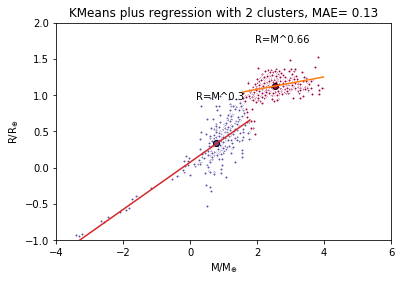

R=M^0.31
R=M^0.65
R=M^0.29


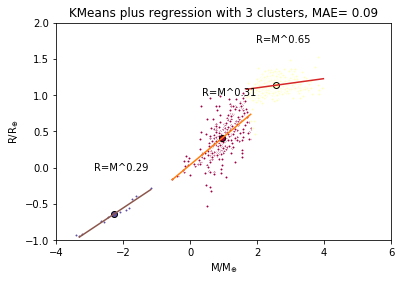

R=M^0.54
R=M^0.29
R=M^0.46
R=M^0.27


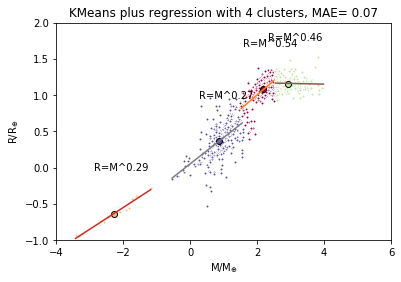

R=M^0.19
R=M^0.62
R=M^0.43
R=M^0.29
R=M^0.57


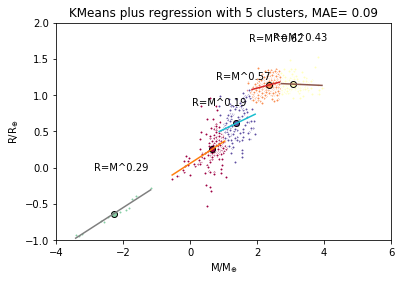

R=M^0.41
R=M^0.69
R=M^0.28
R=M^0.53
R=M^0.55
R=M^0.03


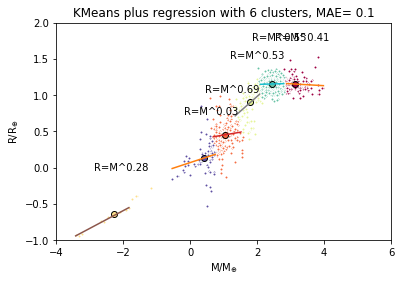

In [9]:
##Run that function over multiple k-values

num_clusters_range=np.arange(2,7)

loss_function=np.zeros(num_clusters_range.shape[0])

for i,num_clusters in enumerate(num_clusters_range):
    k_means, k_means_labels, k_means_cluster_centers=k_means_func(num_clusters)
    variance, reg_fit_x, reg_fit_y=reg_on_clusters(k_means, k_means_labels, k_means_cluster_centers, num_clusters)
    make_plot(k_means, k_means_labels, k_means_cluster_centers, num_clusters, variance, reg_fit_x, reg_fit_y)
    loss_function[i]=np.mean(variance)

## Find the minimum of MAE for each of the clusters

The best k number is 4


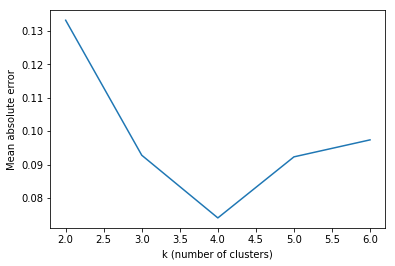

In [10]:

print('The best k number is '+str(num_clusters_range[np.argmin(loss_function)]))

plt.plot(num_clusters_range,loss_function)
plt.xlabel('k (number of clusters)')
plt.ylabel('Mean absolute error')
plt.savefig('figs/k_vs_MAE.pdf')

### Next steps:
Create plot comparing the slope and break points of 2016 data vs ML results. 

Analyze potential physical motivation for breakpoints?

Apply model to remaining 3000+ planets with incomplete mass or radius information

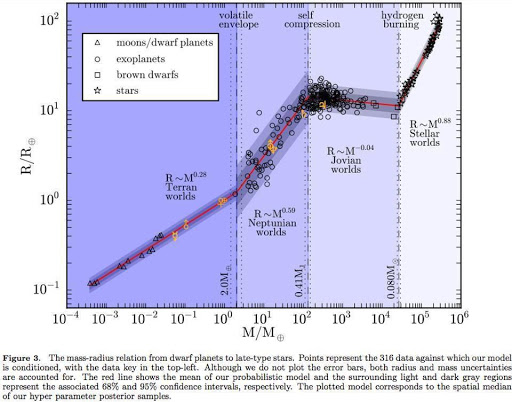

